<div id="colab_button">
  <h1>Uploading models</h1>
  <a target="_blank" href="LINK_GOOGLE_COLAB"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>

_____________________________________________________________________

You've tested and installed BlindAI? Time to upload your model on your server instance! 

You can do it in two lines of code using our Python API, but first your model will need to be converted to the Open Neural Network Exchange Format (ONNX) format. This is because ONNX is a standard enabling framework interoperability, allowing you to easily move models between different machine learning libraries.

In this tutorial, we will show you how to take models from two of the most popular ML libraries, `PyTorch` and `TensorFlow`, convert them to ONNX format, and upload them to BlindAI.

Let's dive in!

## Pre Requisites
_______________________________________

### Installing required dependencies

Unless you're are running this notebook on [Google Colab](LINK_GOOGLE_COLAB), you'll need to have [`Python`](https://www.python.org/downloads/) (3.8 or greater) and [`pip`](https://pypi.org/project/pip/) installed to run this notebook.

Then, you'll need to install the BlindAI-preview package.

In [41]:
# install blindai-preview package
!pip install blindai-preview

We will also need to install some additional dependencies for this notebook:

- [`torch`](https://pytorch.org/): to demonstrate ONNX conversion for PyTorch models
- [`tensorflow`](https://www.tensorflow.org/), `tensorflow_hub`(https://tfhub.dev/) and `tf2onnx`(https://github.com/onnx/tensorflow-onnx) and [`numpy`](https://numpy.org/): to demonstrate ONNX conversion for TensorFlow models
- [`urllib`](https://docs.python.org/3/library/urllib.html), [`PIL`](https://pillow.readthedocs.io/en/stable/), [`torchvision`](https://pytorch.org/vision/stable/index.html), and [`matplotlib`](https://matplotlib.org/) to download and display images used to test our models.


In [ ]:
# install all other required packages
!pip install torch tensorflow tf2onnx numpy torchvision urllib PIL matplotlib

### Launch the BlindAI server

Let's launch an instance of BlindAI's server so we can upload the model. 

For the purposes of this tutorial, we will be using the `blindai_preview.testing` server which has been designed for testing purposes *only*.

In [43]:
# import testing submodule
import blindai_preview.testing

# start the server
srv = blindai_preview.testing.start_mock_server()

BlindAI mock server (version 0.0.8) already installed


>Note that the blindai-preview testing module launches the server in simulation mode. As a result, it doesn't provide hardware protection and **must not be used in production**. We created this option to enable users to quickly and easily test BlindAI without needing to run the server on a machine with Intel SGX hardware. To learn more about how to run the server with hardware protections on, see [our documentation](https://blindai-preview.mithrilsecurity.io/en/latest/).

## PyTorch model
__________________

We will use the pretrained `resnet18` neural network as our example model for this section. The `resnet18` model classifies images and returns possbible labels for the image with their probability of being the correct label.

### Download the model

We'll download the model from `PyTorch Hub`, by using the `hub` module's `load()` method. 

The first argument we provide specifies the GitHub repo and directory where the model can be installed from. The second specifies the name of the model to be downloaded. Then we set the `pretrained` option to `True`.

In [44]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Before exporting, it's very important to ensure the model is set to inference mode. We do that by calling `model.eval()` or `model.train(False)`.

In [45]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### ONNX conversion

To convert our model to ONNX fomat, we will use the `torch.onnx.export()` function.

The `export()` method will execute the model and record a trace of what operators are used to compute the outputs. In order for `export` to be able to perform this "dry-run", we need to supply it with some dummy inputs in the shape the model would expect.

For `resnet18`, the dummy input should be in the following format: `batch_size`, `channel_width`, `image_size`, `image_size`.

The values we provide for each dimension, in this case `batch_size`, `channel_width`, `image_size` and `image_size` will be fixed in the exported ONNX graph, meaning all future input to the model must match this shape. For example, if we set the `batch_size` to 1, users will only be able to upload one image at a time to be inferenced by the model.

There is a way to avoid having to set a fixed value though, by specifying that a certain axes is a dynamic axes in the `export` options. For example, if we specify `batch_size` as a dynamic axes, users will be able to upload one or multiple images to the model at a time.

Let's create our dummy input now:

In [46]:
# create dummy inputs for resnet18 model
dummy_inputs = torch.zeros(1,3,224,224)

The channel width should be `3, representing the RGB values of our image, and the image size should be `224x224`. 

We will set the `batch_size` to `1`, but then specify the first dimension as dynamic with the `dynamic_axes` option.

Since the values used for our dummy input are not important in this tutorial, we will set fill them with `0`.

Now that we have created our dummy inputs, we are ready to call the `onnx.export()` method. We pass the method:
- our PyTorch model,
- the dummy inputs,
- the name we want to give our ONNX file,
- any dynamic axes for input and output values.

In [ ]:
torch.onnx.export(model, dummy_inputs, 
                "resnet18.onnx", 
                dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

> For information about more export options, see the `torch.onnx.export` [documentation](https://pytorch.org/docs/stable/onnx.html#torch.onnx.export).

Our PyTorch model has been succesfully converted!

### Upload the model

To upload the model, we need to connect to the server using BlindAI's `core.connect()` function.

Setting up a production server is not the focus of this tutorial, which is why we've been using a server in `simulation` mode. This means two things: 

- We also need to set the `simulation_mode` parameter to `True` on the client side. This is needed because the client will refuse to connect to an unsecure server otherwise.  
- We also set the `hazmat_http_on_unattested_port` option to `True`. 

  >By default, the `blindai_preview` package requires a HTTPS connection for communications between the client and server on the unattested port 9923. But for testing purposes we opt out of this requirement and connect without a secure connection. This should **not be done in production**, please refer to our documentation to set up a production server.

In [48]:
import blindai_preview 
import blindai_preview

# AI company connects
client_1 = blindai_preview.core.connect(addr="localhost", simulation_mode=True, hazmat_http_on_unattested_port=True)

/usr/local/lib/python3.9/dist-packages/blindai_preview/client.py:506: SimulationModeWarning: BlindAI is running in simulation mode. This mode is provided solely for testing purposes. It does not provide any security since there is no SGX enclave. The simulation mode MUST NOT be used in production.
  warnings.warn(


> For the purposes of this demo, we are running the server on `localhost` using the default ports, but you can modify the host and ports in the `connect()` function.

Finally, we can upload the model using the client `upload_model()` method! 

We'll need to specify the ONNX model's file name via the `model` parameter.

Then we can store and print out our `model_id`, which is used to identify the model when running or deleting the model.

In [49]:
# # AI company uploads model to server
response = client_1.upload_model(model="./resnet18.onnx")
PY_MODEL_ID = response.model_id
print(PY_MODEL_ID)

0103fbaf-f3b7-4ee2-9cfc-62d53d5b8e5c


The PyTorch model has now been successfully uploaded to the BlindAI server and is ready to be consumed by users.

### Testing the model

We can now perform a quick test to check the model is working as expected.

Firstly, we need an image to test our model with. We will take a testing image supplied by the PyTorch Hub github. We take the pre-processing code provided by PyTorch to resize our image and transform it to a torch.Tensor as this is the expected input type for the ResNet18 model.

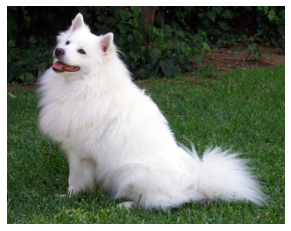

In [50]:
from torchvision import transforms
import urllib
from PIL import Image
from matplotlib import pyplot as plt

# Download an example image from the pytorch website
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
input_image = Image.open(filename)
plt.imshow(input_image)
plt.axis('off')


# preprocessing function to resize image and turn into tensor
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)


# create a mini-batch as expected by the model
input_batch = input_tensor.unsqueeze(0)

Now that our input is compatible with the model, we can execute the model by using the `run_model` method on our BlindAiConnection object, passing the model ID as the first parameter and our input Tensor as the second. We save the RunModelResponse in the `prediction` variable.

In [51]:
prediction = client_1.run_model(PY_MODEL_ID, input_batch)

Next we download the labels that correspond with this pre-trained model using `requests.get()` and convert them into a list with the `response.text.split()` method.

In [52]:
import requests

# get labels as list
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")

Finally, we get the re-scale our results to get the correct output and print them out.

In [53]:
# Get results from RunModelReponse
output = prediction.output[0].as_torch()

#Find the score in terms of percentage by using torch.nn.functional.softmax function
#which normalizes the output to range [0,1]
probabilities = torch.nn.functional.softmax(output, dim=1)

# get index of item with highest probability
index = probabilities.argmax().item()

# get label at this index
print("Label is:", labels[index])

# Get the probability- which is the highest probability from output
print("Probability is:", probabilities.max().item())

Label is: Samoyed
Probability is: 0.8846225142478943


The model has correctly labelled our image as a Samoyed dog with an 88% confidence value.

## TensorFlow model
__________________________

Let's now take a look at how we can convert `TensorFlow saved models` to ONNX using the [`tf2onnx.convert` tool](https://github.com/onnx/tensorflow-onnx). This is the recommended and most popular way to convert TensorFlow models to ONNX, but you can also convert to ONNX from different formats like `graphdef` or `checkpoint` format.

>For more information about converting TensorFlow models from `checkpoints` or `graphdef` format, please see the [`tf2onnx` documentation](https://github.com/onnx/tensorflow-onnx).

### Loading the model

We'll start by loading the built-in MobileNet model, which is a computer vision model open-sourced by Google. The model returns labels for the items it has identified in the image.

By importing and initializing the MobileNet class from the `keras.applications.mobilenet` module, we get back a Keras model instance of the MobileNet model. We then transform this into the SavedModel format by using the `save()` method and providing a name for our `SavedModel` directory.

In [54]:
from tensorflow.keras.applications.mobilenet import MobileNet

# initalize pre-trained ResNet50 model
model = MobileNet(weights='imagenet')

# compile model
model.compile()

# convert model to SavedModel format
model.save("my_model")

A `SavedModel` is a directory, containing a `saved_model.pb` file where the TensorFlow model is stored, as well as any additional required files. Here we create our `SavedModel` directory in our current working directory and call it "my model".



### ONNX Conversion

Now that we our model in `SavedModel` format we can use the `tf2onnx.convert` tool to convert our model to ONNX. We provide the path to our `saved-model` and the path we want our `output` onnx file to have.

In [55]:
# convert SavedModel to onnx
!python -m tf2onnx.convert --saved-model ./my_model --output ./mobilenet_tf.onnx

2023-03-23 12:33:45.236399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 12:33:45.236532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-23 12:33:45.236551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package

We now have a `mobilenet_tf.onnx` file in our current working directory ready to be uploaded to BlindAI.

### Upload the model

We are now ready to upload the model to the BlindAI server using the `upload_model` method.

We then print out the model's ID which would be used later to identify the model when performing operations in the BlindAI API.

In [56]:
# AI company uploads model to server
client_1 = blindai_preview.core.connect(addr="localhost", simulation_mode=True, hazmat_http_on_unattested_port=True)
response = client_1.upload_model(model="./mobilenet_tf.onnx")
TF_MODEL_ID = response.model_id
print(TF_MODEL_ID)

/usr/local/lib/python3.9/dist-packages/blindai_preview/client.py:506: SimulationModeWarning: BlindAI is running in simulation mode. This mode is provided solely for testing purposes. It does not provide any security since there is no SGX enclave. The simulation mode MUST NOT be used in production.
  warnings.warn(


b0703755-bb90-47f4-8472-cede8c898b21


Next, let's download a testing image provided by TensorFlow.

(-0.5, 223.5, 223.5, -0.5)

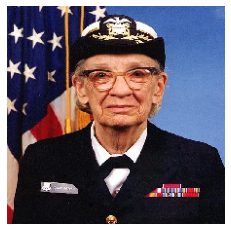

In [57]:
import os
import tempfile

import numpy as np
import tensorflow as tf


# get image for testing
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")

# load image to desired size
img = tf.keras.utils.load_img(file, target_size=[224, 224])

# display image for tutorial
plt.imshow(img)
plt.axis('off')

Next, we need to perform the necessary pre-processing on the image. Firstly, we need to convert our image to numpy.ndarray format using the `image_to_array()` method provided to us in `keras.utils`. 

We then can use a MobileNet-specific pre-processing method provided built into `keras.application` to ensure our image is compatible with the model- we also add a new axis to the image so that its dimensions are as expected by the MobileNet model.

In [58]:
# convert image to numpy.ndarray
x = tf.keras.utils.img_to_array(img)

# add dimension and perform necessary preprocessing
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])


Next up, we need to download a file containg the labels for this model and convert them into a numpy.ndarray.

In [59]:
# get labels
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

# create array of labels from file
imagenet_labels = np.array(open(labels_path).read().splitlines())

Now that we have prepared our input and labels, we are ready to run the model in BlindAI.

We use the `run_model` method on our `BlindAI Connection` object, providing the ID of our model and our input image.

We then get the output of the model as a numpy.ndarray.

Finally, we order labels by confidence interval of a match and take the top 5 results. We must apply an offset of +1 in order for these indices to match up correctly with the labels. We are then able to print out the corresponding labels for our indices.

In [60]:
# run model on our input image in BlindAI
ret = client_1.run_model(TF_MODEL_ID, x)

# convert results to numpy ndarray
output = ret.output[0].as_numpy()

# Get indices for top 5 most probable labels, apply offset
indices = np.argsort(output)[0,::-1][:5]+1

# decode results
decoded = imagenet_labels[indices]
print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


In this case, the top three labels correctly identify elements from out image.

>Note that exported ONNX models must be compatible with the Rust crate `tract-onnx` to be executed in BlindAI. If you are experiencing issues, we recommend using PyTorch models for maximum compatibility.

## Conclusions
____________________________________

This is the end of our tutorial on uploading models to BlindAI.

We have seen how to:

* **Convert** PyTorch and TensorFlow models to ONNX format.
* **Upload** these models to BlindAI.
* **Run** these models in BlindAI.

Please check out the rest of our [BlindAI documentation](https://blindai-preview.mithrilsecurity.io/en/latest/) to see more examples of how you can use BlindAI to deploy AI models without compromising the safety of user data or models.